In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load the training set
df = pd.read_csv(r'.\gamified_dataset/Dyt-desktop.csv')

print("#-----> First 5 rows of the training set:\n")
df.head(5)

#-----> First 5 rows of the training set:



,Gender,Nativelang,Otherlang,Age,Clicks1,Hits1,Misses1,Score1,Accuracy1,Missrate1,...,Score31,Accuracy31,Missrate31,Clicks32,Hits32,Misses32,Score32,Accuracy32,Missrate32,Dyslexia
0,Male,No,Yes,7,10,10,0,10,1.0,0.0,...,0,0.000000,0.00,17,2,0,2,0.117647,0.000000,No
1,Female,Yes,Yes,13,12,12,0,12,1.0,0.0,...,4,0.114286,0.00,26,2,2,2,0.076923,0.076923,Yes
2,Female,No,Yes,7,6,6,0,6,1.0,0.0,...,4,0.114286,0.00,26,1,3,1,0.038462,0.115385,No
3,Female,No,Yes,7,0,0,0,0,0.0,0.0,...,0,0.000000,0.00,1,0,0,0,0.000000,0.000000,No
4,Female,No,Yes,8,4,4,0,4,1.0,0.0,...,1,25.000000,0.05,26,2,2,2,0.076923,0.076923,No


In [3]:
df=df.drop(columns = ['Otherlang'])

In [4]:
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['Nativelang'] = label_encoder.fit_transform(df['Nativelang'])
df['Dyslexia'] = label_encoder.fit_transform(df['Dyslexia'])

In [5]:
df.head(5)

,Gender,Nativelang,Age,Clicks1,Hits1,Misses1,Score1,Accuracy1,Missrate1,Clicks2,...,Score31,Accuracy31,Missrate31,Clicks32,Hits32,Misses32,Score32,Accuracy32,Missrate32,Dyslexia
0,1,0,7,10,10,0,10,1.0,0.0,5,...,0,0.000000,0.00,17,2,0,2,0.117647,0.000000,0
1,0,1,13,12,12,0,12,1.0,0.0,11,...,4,0.114286,0.00,26,2,2,2,0.076923,0.076923,1
2,0,0,7,6,6,0,6,1.0,0.0,6,...,4,0.114286,0.00,26,1,3,1,0.038462,0.115385,0
3,0,0,7,0,0,0,0,0.0,0.0,0,...,0,0.000000,0.00,1,0,0,0,0.000000,0.000000,0
4,0,0,8,4,4,0,4,1.0,0.0,8,...,1,25.000000,0.05,26,2,2,2,0.076923,0.076923,0


In [5]:
X_features = df.drop(['Dyslexia'], axis=1)
y_labels= df['Dyslexia']

In [14]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix

# Weighted attributes to balance classes
class_weights = {0: 1, 1: 8}  # Assuming 0 is 'no' (non-dyslexia) and 1 is 'yes' (dyslexia)

# Initialize Random Forest classifier
# rf_classifier = RandomForestClassifier(n_estimators=50, max_depth=None, class_weight=class_weights, random_state=42, bootstrap=False,)

# RandomForestClassifier(bootstrap=False, class_weight='balanced',
#                        max_features='auto', min_samples_leaf=4,
#                        n_estimators=50)

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(class_weight=class_weights, random_state=42)

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'bootstrap': [True, False],
    'min_samples_leaf': [1, 2, 4]
}

# Create 10-fold stratified cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(rf_classifier, param_grid, scoring='recall', cv=cv, n_jobs=-1)
grid_search.fit(X_features, y_labels)

# Get the best model from the grid search
best_rf_classifier = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Initialize arrays to store true labels and predicted probabilities
true_labels = []
predicted_probabilities = []

# Iterate through the cross-validation splits
for train_index, test_index in cv.split(X_features, y_labels):
    X_train, X_test = X_features.iloc[train_index], X_features.iloc[test_index]
    y_train, y_test = y_labels.iloc[train_index], y_labels.iloc[test_index]

    # Train the best Random Forest classifier
    best_rf_classifier.fit(X_train, y_train)

    # Predict probabilities on the test set
    y_prob = best_rf_classifier.predict_proba(X_test)[:, 1]

    # Store true labels and predicted probabilities
    true_labels.extend(y_test)
    predicted_probabilities.extend(y_prob)

Best Hyperparameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 100}


In [23]:
# Calculate precision-recall curve and area under the curve (AUC)
precision, recall, thresholds = precision_recall_curve(true_labels, predicted_probabilities)
auc_score = auc(recall, precision)

# Find the threshold for a similar weight of false negatives and false positives
desired_weight_ratio = 5  # Set the desired weight ratio here

# Calculate the updated threshold
updated_threshold = min(thresholds[np.where(np.abs(desired_weight_ratio * recall - (1 / (1 - precision))) == 
                                           np.min(np.abs(desired_weight_ratio * recall - (1 / (1 - precision)))))])

# Print the updated threshold
print("Updated Threshold:", updated_threshold)

# Apply the updated threshold to make predictions on the entire dataset
y_pred_updated = (predicted_probabilities >= updated_threshold).astype(int)

# Print the classification report
print("Classification Report (Updated Threshold):")
classification_report_rf = classification_report(y_labels, y_pred_updated)
print(classification_report_rf)

# Print the confusion matrix
print("Confusion Matrix (Updated Threshold):")
print(confusion_matrix(y_labels, y_pred_updated))

Updated Threshold: 0.4874704180884006
Classification Report (Updated Threshold):
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      3252
           1       0.09      0.07      0.08       392

    accuracy                           0.82      3644
   macro avg       0.49      0.49      0.49      3644
weighted avg       0.80      0.82      0.81      3644

Confusion Matrix (Updated Threshold):
[[2961  291]
 [ 363   29]]


C:\Users\Haneen\AppData\Local\Temp\ipykernel_18688\3400372111.py:9: RuntimeWarning: divide by zero encountered in divide
  updated_threshold = min(thresholds[np.where(np.abs(desired_weight_ratio * recall - (1 / (1 - precision))) ==
C:\Users\Haneen\AppData\Local\Temp\ipykernel_18688\3400372111.py:10: RuntimeWarning: divide by zero encountered in divide
  np.min(np.abs(desired_weight_ratio * recall - (1 / (1 - precision)))))])


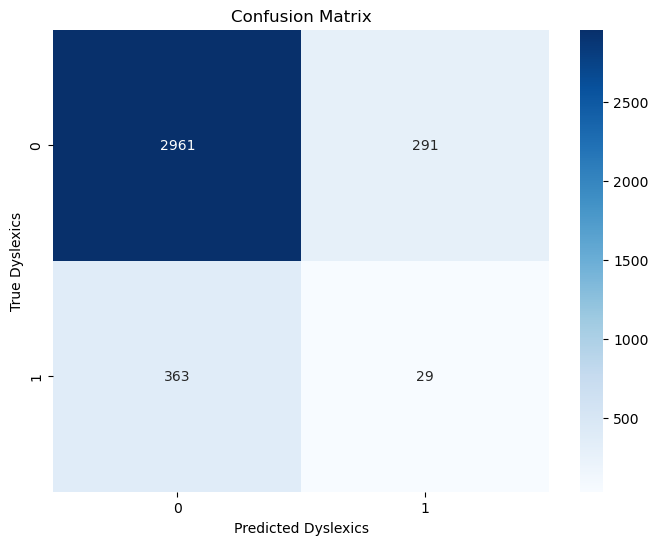

In [24]:
cm = confusion_matrix(y_labels, y_pred_updated)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Dyslexics')
plt.ylabel('True Dyslexics')
plt.title('Confusion Matrix')
plt.show()

In [8]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels)


# Weighted attributes to balance classes
class_weights = {0: 1, 1: 8}  # Assuming 0 is 'no' (non-dyslexia) and 1 is 'yes' (dyslexia)

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(class_weight=class_weights, random_state=42)

# Create 10-fold stratified cross-validation on the training set
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'bootstrap': [True, False],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find the best hyperparameters on the training set
grid_search = GridSearchCV(rf_classifier, param_grid, scoring='recall', cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_rf_classifier = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Initialize arrays to store true labels and predicted probabilities on the test set
true_labels_test = []
predicted_probabilities_test = []

# Train the best Random Forest classifier on the entire training set
best_rf_classifier.fit(X_train, y_train)

# Predict probabilities on the test set
y_prob_test = best_rf_classifier.predict_proba(X_test)[:, 1]

# Store true labels and predicted probabilities on the test set
true_labels_test.extend(y_test)
predicted_probabilities_test.extend(y_prob_test)


Best Hyperparameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 50}


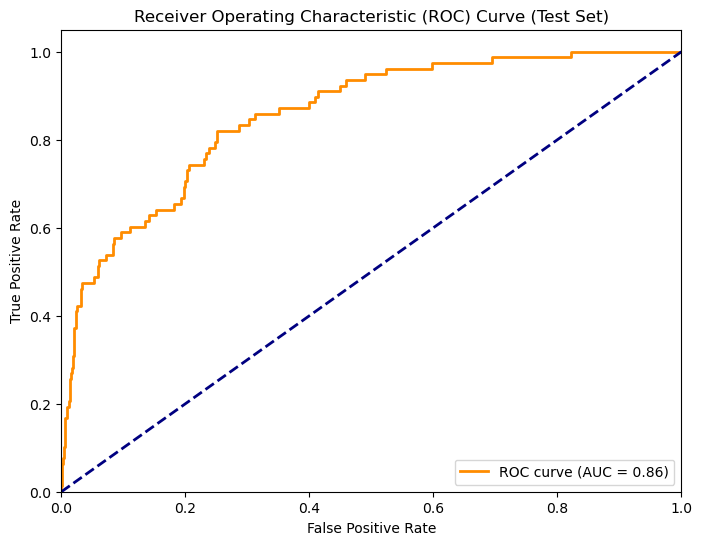

AUC Score on Test Set: 0.8556658395368073
Updated Threshold on Test Set: 0.23383731896037413
Classification Report (Updated Threshold) on Test Set:
              precision    recall  f1-score   support

           0       0.97      0.69      0.81       651
           1       0.25      0.85      0.38        78

    accuracy                           0.71       729
   macro avg       0.61      0.77      0.59       729
weighted avg       0.90      0.71      0.76       729

Confusion Matrix (Updated Threshold) on Test Set:
[[448 203]
 [ 12  66]]


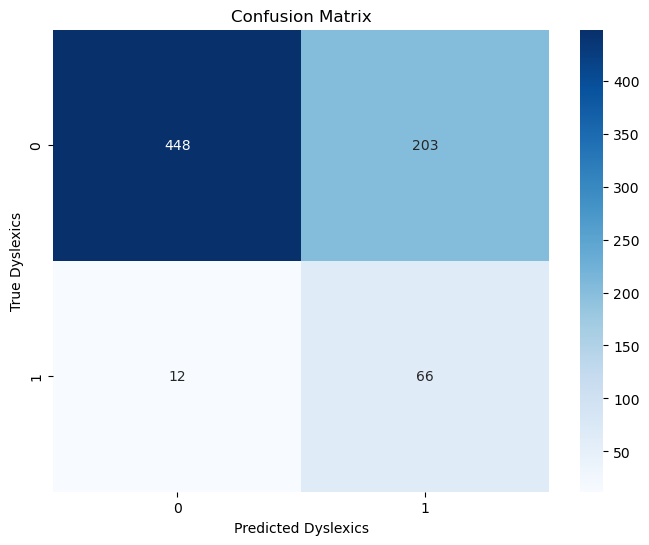

In [9]:
from sklearn.metrics import roc_curve

# Calculate ROC curve and AUC on the test set
fpr_test, tpr_test, thresholds_test = roc_curve(true_labels_test, predicted_probabilities_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Test Set)')
plt.legend(loc='lower right')
plt.show()

# Print the AUC score on the test set
print("AUC Score on Test Set:", roc_auc_test)

# Find the threshold for a similar weight of false negatives and false positives on the test set
desired_weight_ratio_test = 2  # Set the desired weight ratio here
updated_threshold_test = min(thresholds_test[np.where(np.abs(desired_weight_ratio_test * (1 - tpr_test) - (fpr_test)) == 
                                           np.min(np.abs(desired_weight_ratio_test * (1 - tpr_test) - (fpr_test))))])

# Print the updated threshold on the test set
print("Updated Threshold on Test Set:", updated_threshold_test)

# Apply the updated threshold to make predictions on the entire test set
y_pred_test = (predicted_probabilities_test >= updated_threshold_test).astype(int)

# Print the classification report on the test set
classification_rep_test = classification_report(y_test, y_pred_test)
print("Classification Report (Updated Threshold) on Test Set:")
print(classification_rep_test)

# Print the confusion matrix on the test set
print("Confusion Matrix (Updated Threshold) on Test Set:")
print(confusion_matrix(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Dyslexics')
plt.ylabel('True Dyslexics')
plt.title('Confusion Matrix')
plt.show()

In [10]:
import joblib

# Save the classification report to a file
with open('classification_report_RF.txt', 'w') as file:
    file.write(classification_rep_test)

# Save the model weights using joblib
joblib.dump(best_rf_classifier, 'random_forest_model.joblib')

['random_forest_model.joblib']